In [1]:
# Import libraries and dependencies
from os import getenv
import pandas as pd
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
import numpy as np
from datetime import date, timedelta
from pathlib import Path


# Load .env environment variables
from dotenv import load_dotenv
load_dotenv()

#neural network imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [20]:
def get_bars_alpaca(start_date = pd.Timestamp("2016-01-01", tz="America/New_York").isoformat(),end_date = pd.Timestamp("2023-03-24", tz="America/New_York").isoformat() ,ticker='SOYB'):
    load_dotenv()
    alpaca_api_key=getenv('ALPACA_API_KEY')
    secret_key=getenv('ALPACA_SECRET_KEY')
    if type(alpaca_api_key) == 0:
        raise Exception("No ALPACA API KEY was loaded. Please save a .env file containing an ALPACA_API_KEY in the local directory.")
    if type(secret_key) == 0:
        raise Exception("No ALPACA SECRET KEY was loaded. Please save a .env file containing an ALPACA_SECRET_KEY in the local directory.")
    api=REST(key_id=alpaca_api_key,secret_key=secret_key)
    df=api.get_bars("SOYB", TimeFrame.Day, start_date, end_date, adjustment='raw').df
    return(df)

def make_features_targets(dataframe,close=True,volume=False,trade_count=False,vwap=True):
    if close == True:
        dataframe['previous_close']=dataframe['close'].shift(1)
    if volume == True:
        dataframe['previous_volume']=dataframe['volume'].shift(1)
    if trade_count == True:
        dataframe['previous_trade_count']=dataframe['trade_count'].shift(1)
    if vwap == True:
        dataframe['previous_vwap']=dataframe['vwap'].shift(1)
    dataframe.dropna(inplace=True)
    X=dataframe[dataframe.columns[dataframe.columns.str.contains('previous')]]
    y=dataframe[['close']]
    return(X,y)


In [21]:
X, y = make_features_targets(get_bars_alpaca(),close=True,volume=True,trade_count=False,vwap=True)
y

,close
timestamp,
2016-01-05 05:00:00+00:00,17.1934
2016-01-06 05:00:00+00:00,17.2645
2016-01-07 05:00:00+00:00,17.3195
2016-01-08 05:00:00+00:00,17.3300
2016-01-11 05:00:00+00:00,17.2500
...,...
2023-03-20 04:00:00+00:00,27.0900
2023-03-21 04:00:00+00:00,26.8100
2023-03-22 04:00:00+00:00,26.3300


In [22]:
training_start_date = '2021-03-01'  #'2017-01-01'
training_end_date = '2022-02-28'    #2017-12-31'
testing_start_date = '2022-03-01'  #'2018-01-01'
testing_end_date = '2023-02-28'   #'2018-12-31'
X_train=X.loc[training_start_date:training_end_date,:]
y_train=y.loc[training_start_date:training_end_date,:]
X_test=X.loc[testing_start_date:testing_end_date,:]
y_test=y.loc[testing_start_date:testing_end_date,:]
  
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_scaler = StandardScaler()
    
# Fit the scaler
X_scaler.fit(X_train)
    
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [23]:
nn_model_regression = Sequential()
number_inputs = len(X.columns)
hidden_nodes_layer1 = 4
#hidden_nodes_layer2 = 2
number_classes = 1

#add layers
nn_model_regression.add(Dense(units=hidden_nodes_layer1, input_shape=(X_train.shape[1],), activation="relu", input_dim=number_inputs))
#nn_model_regression.add(Dense(units=hidden_nodes_layer2, activation="relu"))

#add output layer
nn_model_regression.add(Dense(units=number_classes, activation="linear"))
nn_model_regression.summary()

nn_model_regression.compile(loss="mse", optimizer="adam")
nn_model_fit = nn_model_regression.fit(X_train_scaled,y=y_train['close'], epochs=800)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 4)                 16        
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Epoch 1/800
8/8 [==============================] - 1s 1ms/step - loss: 525.5175
Epoch 2/800
8/8 [==============================] - 0s 1ms/step - loss: 523.9177
Epoch 3/800
8/8 [==============================] - 0s 1ms/step - loss: 522.3415
Epoch 4/800
8/8 [==============================] - 0s 2ms/step - loss: 520.7838
Epoch 5/800
8/8 [==============================] - 0s 1ms/step - loss: 519.1945
Epoch 6/800
8/8 [==============================] - 0s 

<AxesSubplot:>

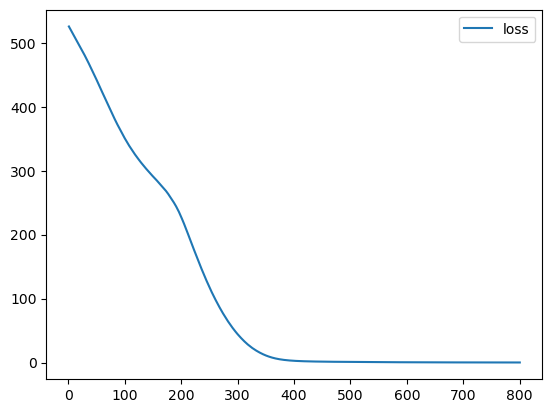

In [24]:
model_plot = pd.DataFrame(nn_model_fit.history, index=range(1, len(nn_model_fit.history["loss"]) + 1))
model_plot.plot(y="loss")

In [28]:
file_path = Path("nn_regression.h5")

nn_model_regression.save(file_path)

8/8 [==============================] - 0s 855us/step


<AxesSubplot:xlabel='timestamp'>

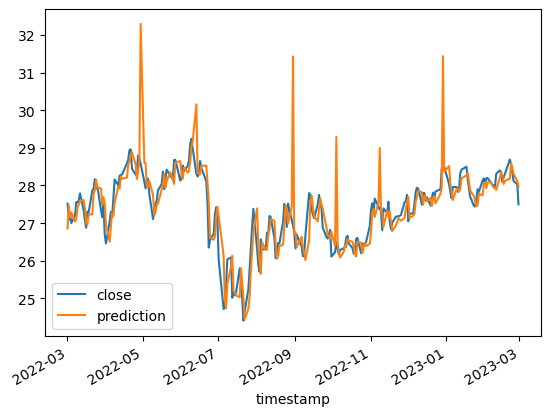

In [26]:
nn_pred = nn_model_regression.predict(X_test_scaled)
compare_df = pd.DataFrame(index = X_test.index) 
compare_df['close'] = y_test.values
compare_df['prediction'] = nn_pred
compare_df.plot()